In [45]:
import pecnet as pc
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt

from models import Model, FinalModel

In [46]:
import tensorflow as tf
import os 
import random
#This is for getting the same results. 
def reset_random_seeds(seed):
   os.environ['PYTHONHASHSEED']=str(seed)
   tf.random.set_seed(seed)
   np.random.seed(seed)
   random.seed(seed)
reset_random_seeds(42)

In [47]:
def read(station, start, end):
    if isinstance(start, datetime):
        start = np.datetime64(start)
    if isinstance(end, datetime):
        end = np.datetime64(end)

    path = f'{station}_1min.dat'
    with open(path, "rb") as file:
        file.seek(int((start-np.datetime64('2000-01-01'))/np.timedelta64(1, 'm'))*4)
        minutes = int((end-start)/np.timedelta64(1, 'm'))
        data = np.frombuffer(file.read(minutes*4), np.float32)
    times = np.arange(start, end, np.timedelta64(1, 'm'))
    return times, data

In [48]:
start = np.datetime64('2002-01-01') # enter time range
end = np.datetime64('2012-12-31') # 2000 to 2040 time range
DATA_FOLDER = "data/"
STATION_NAME = "54_SAK_UNIV_PROB"

timesSignal, dataSignal = read(DATA_FOLDER + STATION_NAME, start, end)
energy = pd.read_csv("energy_release.csv", index_col=0).fillna(0).reset_index()
energy["date"] = pd.to_datetime(energy["index"])
efd_df = pd.DataFrame({"value":dataSignal}, index=timesSignal)
#drop_idx = np.argwhere(efd_df.index == pd.to_datetime("2012-12-31 00:00:00")).flatten()[0]#Drop last day
#efd_df = efd_df.iloc[:drop_idx].copy()
energy["E_weekly_mean"] = np.flip(pc.rolling_mean(np.flip(energy["E_daily"].to_numpy()), 7))
energy = energy.drop(0).reset_index(drop=True)

In [49]:
start2 = np.datetime64('2002-01-01') # enter time range
end2 = np.datetime64('2012-12-31') # 2000 to 2040 time range
DATA_FOLDER2 = "data/"
STATION_NAME2 = "34_YSL_HVHO_PROB"

timesSignal2, dataSignal2 = read(DATA_FOLDER2 + STATION_NAME2, start2, end2)
efd_df2 = pd.DataFrame({"value":dataSignal2}, index=timesSignal2)

In [50]:
df = energy.copy()
df["prev7days"] = pc.rolling_op(energy["E_weekly_mean"].values, 7, np.nanmean, fill=True, step=1)
df["y_aftersplit"] = np.append(df["prev7days"].values[1:], [0])
df.head(20)

,index,E_daily,date,E_weekly_mean,prev7days,y_aftersplit
0,2002-01-02,0.000000,2002-01-02,107.832263,15.404609,30.809218
1,2002-01-03,0.000000,2002-01-03,107.832263,30.809218,46.213827
2,2002-01-04,754.825839,2002-01-04,107.832263,46.213827,46.213827
3,2002-01-05,0.000000,2002-01-05,0.000000,46.213827,46.213827
4,2002-01-06,0.000000,2002-01-06,0.000000,46.213827,46.213827
5,2002-01-07,0.000000,2002-01-07,0.000000,46.213827,46.213827
6,2002-01-08,0.000000,2002-01-08,0.000000,46.213827,46.213827
7,2002-01-09,0.000000,2002-01-09,107.832263,46.213827,46.213827
8,2002-01-10,0.000000,2002-01-10,107.832263,46.213827,46.213827
9,2002-01-11,0.000000,2002-01-11,107.832263,46.213827,80.426639


In [51]:
pd.set_option('max_colwidth', 160)
df2 = df.copy()
df2["prev7days"] =  pc.rolling_op(energy["E_daily"].values, 7, np.nanmean, fill=True, step=1, include_first=False)
DAILY_WINDOW = 8
ENERGY_SPLIT_INDEX= int(energy.shape[0] / 100 * 80)
seventh_data = energy.E_daily.to_numpy().flatten()
X_7, y_7 = pc.get_xy(seventh_data, DAILY_WINDOW, step =1, fill=True, include_first=False)
df2 = df2.drop(columns=["y_aftersplit"])
#df2["y_aftersplit"] = np.append(y_train_7, y_test_7)
df2["X_7"] = [str(x) for x in X_7]
df2["y_7"] = y_7
df2.head(50)

,index,E_daily,date,E_weekly_mean,prev7days,X_7,y_7
0,2002-01-02,0.000000,2002-01-02,107.832263,0.000000,[0. 0. 0. 0. 0. 0. 0. 0.],0.000000
1,2002-01-03,0.000000,2002-01-03,107.832263,0.000000,[0. 0. 0. 0. 0. 0. 0. 0.],754.825839
2,2002-01-04,754.825839,2002-01-04,107.832263,0.000000,[0. 0. 0. 0. 0. 0. 0. 0.],0.000000
3,2002-01-05,0.000000,2002-01-05,0.000000,107.832263,[ 0. 0. 0. 0. 0.\n 0. 0. 754.82583925],0.000000
4,2002-01-06,0.000000,2002-01-06,0.000000,107.832263,[ 0. 0. 0. 0. 0.\n 0. 754.82583925 0. ],0.000000
5,2002-01-07,0.000000,2002-01-07,0.000000,107.832263,[ 0. 0. 0. 0. 0.\n 754.82583925 0. 0. ],0.000000
6,2002-01-08,0.000000,2002-01-08,0.000000,107.832263,[ 0. 0. 0. 0. 754.82583925\n 0. 0. 0. ],0.000000
7,2002-01-09,0.000000,2002-01-09,107.832263,107.832263,[ 0. 0. 0. 754.82583925 0.\n 0. 0. 0. ],0.000000
8,2002-01-10,0.000000,2002-01-10,107.832263,107.832263,[ 0. 0. 754.82583925 0. 0.\n 0. 0. 0. ],0.000000
9,2002-01-11,0.000000,2002-01-11,107.832263,107.832263,[ 0. 754.82583925 0. 0. 0.\n 0. 0. 0. ],0.000000


In [52]:
means = []
stds = []

group = efd_df.groupby(pd.Grouper(freq='22.5min', label='right', closed='right'))
mean_efd = group.mean()
stds_efd = group.std()
means.append(mean_efd.reset_index().iloc[:-1])
stds.append(stds_efd.reset_index().iloc[:-1])

freqs = ["3h","1d"]
for freq in freqs:
    group_mean = mean_efd.groupby(pd.Grouper(freq=freq, label='right', closed='right'))
    group_std = stds_efd.groupby(pd.Grouper(freq=freq, label='right', closed='right'))

    means.append(group_mean.max().reset_index().iloc[:-1])
    stds.append(group_std.max().reset_index().iloc[:-1])

freqs = ["22.5min", "3h","1d"]

In [53]:
means2 = []
stds2 = []

group2 = efd_df2.groupby(pd.Grouper(freq='22.5min', label='right', closed='right'))
mean_efd2 = group2.mean()
stds_efd2 = group2.std()
means2.append(mean_efd2.reset_index().iloc[:-1])
stds2.append(stds_efd2.reset_index().iloc[:-1])

freqs2 = ["3h","1d"]
for freq in freqs2:
    group_mean2 = mean_efd2.groupby(pd.Grouper(freq=freq, label='right', closed='right'))
    group_std2 = stds_efd2.groupby(pd.Grouper(freq=freq, label='right', closed='right'))

    means2.append(group_mean2.max().reset_index().iloc[:-1])
    stds2.append(group_std2.max().reset_index().iloc[:-1])

freqs2 = ["22.5min", "3h","1d"]

In [54]:
split_idx = int(energy.shape[0] / 100 * 80)
print(split_idx)

3213


In [55]:
for i, mean_df in enumerate(means):
    print(freqs[i], mean_df.loc[mean_df["index"].dt.date == energy.date[split_idx]].iloc[0])

C:\Users\srknm\AppData\Local\Temp\ipykernel_8052\2136075922.py:2: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  print(freqs[i], mean_df.loc[mean_df["index"].dt.date == energy.date[split_idx]].iloc[0])


22.5min index    2010-10-20 00:00:00
value           10610.703125
Name: 205696, dtype: object
3h index    2010-10-20 00:00:00
value           10611.897461
Name: 25712, dtype: object
1d index    2010-10-20 00:00:00
value              10617.375
Name: 3214, dtype: object


In [56]:
for i, mean_df in enumerate(means2):
    print(freqs2[i], mean_df.loc[mean_df["index"].dt.date == energy.date[split_idx]].iloc[0])

C:\Users\srknm\AppData\Local\Temp\ipykernel_8052\2748087817.py:2: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  print(freqs2[i], mean_df.loc[mean_df["index"].dt.date == energy.date[split_idx]].iloc[0])


22.5min index    2010-10-20 00:00:00
value           10703.692383
Name: 205696, dtype: object
3h index    2010-10-20 00:00:00
value           10714.253906
Name: 25712, dtype: object
1d index    2010-10-20 00:00:00
value           10714.253906
Name: 3214, dtype: object


In [57]:
# FIRST_SPLIT_INDEX = 205696
# SECOND_SPLIT_INDEX = 25712
# THIRD_SPLIT_INDEX = 3214

ENERGY_SPLIT_INDEX = split_idx
HOURLY_WINDOW = 8 # Last 3 hours
DAILY_WINDOW = 8 # Last 1 day
WEEKLY_WINDOW = 8 # Last 8 days

FIRST_STEP = int(24*60 / 22.5) # 64
SECOND_STEP = int(24*60 / (22.5 * 8))
THIRD_STEP = 1 # 64

HOURLY_START = FIRST_STEP  - HOURLY_WINDOW
DAILY_START  = SECOND_STEP - DAILY_WINDOW 
WEEKLY_START = THIRD_STEP  - WEEKLY_WINDOW # Its minus -7, So you can either fill the data, or cut the first 7 days(need to convert to their freq) from the other ones

op = np.nanmean
first_data =  means[2].value.to_numpy().flatten()
second_data = stds[2].value.to_numpy().flatten()

third_data = means[1].value.to_numpy().flatten()
fourth_data = stds[1].value.to_numpy().flatten()

fifth_data = means[0].value.to_numpy().flatten()
sixth_data = stds[0].value.to_numpy().flatten()

output_data = energy.E_weekly_mean.to_numpy().flatten()

# we don't use y_train s and y_test s 
X_train, X_test, y_train, y_test, mean = pc.prepare_and_split_data(first_data, WEEKLY_WINDOW, step=THIRD_STEP, fill=True, window_split_index=ENERGY_SPLIT_INDEX, include_first=False)
X_train_2, X_test_2, y_train_2, y_test_2, mean_2 = pc.prepare_and_split_data(second_data, WEEKLY_WINDOW, step=THIRD_STEP, fill=True, window_split_index=ENERGY_SPLIT_INDEX, include_first=False)

X_train_3, X_test_3, y_train_3, y_test_3, mean_3 = pc.prepare_and_split_data(third_data[DAILY_START:], DAILY_WINDOW, step=SECOND_STEP, window_split_index=ENERGY_SPLIT_INDEX)
X_train_4, X_test_4, y_train_4, y_test_4, mean_4 = pc.prepare_and_split_data(fourth_data[DAILY_START:], DAILY_WINDOW, step=SECOND_STEP, window_split_index=ENERGY_SPLIT_INDEX)

X_train_5, X_test_5, y_train_5, y_test_5, mean_5 = pc.prepare_and_split_data(fifth_data[HOURLY_START:], HOURLY_WINDOW,  step=FIRST_STEP, window_split_index=ENERGY_SPLIT_INDEX)
X_train_6, X_test_6, y_train_6, y_test_6, mean_6 = pc.prepare_and_split_data(sixth_data[HOURLY_START:], HOURLY_WINDOW,  step=FIRST_STEP, window_split_index=ENERGY_SPLIT_INDEX)

# this is only for output_data when using it only as y_train
y_train_7, y_test_7 = pc.label_train_test(y=output_data, split_index=ENERGY_SPLIT_INDEX)

# this is only for output_data when using it only as X_train (we cannot use y_train_7 and y_test_7 since prepare_and_split_data() does normalization + wavelet)
seventh_data = energy.E_daily.to_numpy().flatten()
X_train_7, X_test_7, _, _, mean_7 = pc.prepare_and_split_data(seventh_data, DAILY_WINDOW, fill=True, window_split_index=ENERGY_SPLIT_INDEX, include_first=False)

In [58]:
first_data2 =  means2[2].value.to_numpy().flatten()
second_data2 = stds2[2].value.to_numpy().flatten()

third_data2 = means2[1].value.to_numpy().flatten()
fourth_data2 = stds2[1].value.to_numpy().flatten()

fifth_data2 = means2[0].value.to_numpy().flatten()
sixth_data2 = stds2[0].value.to_numpy().flatten()

# we don't use y_train s and y_test s 
X_train2, X_test2, y_train2, y_test2, mean2 = pc.prepare_and_split_data(first_data2, WEEKLY_WINDOW, step=THIRD_STEP, fill=True, window_split_index=ENERGY_SPLIT_INDEX, include_first=False)
X_train_22, X_test_22, y_train_22, y_test_22, mean_22 = pc.prepare_and_split_data(second_data2, WEEKLY_WINDOW, step=THIRD_STEP, fill=True, window_split_index=ENERGY_SPLIT_INDEX, include_first=False)

X_train_32, X_test_32, y_train_32, y_test_32, mean_32 = pc.prepare_and_split_data(third_data2[DAILY_START:], DAILY_WINDOW, step=SECOND_STEP, window_split_index=ENERGY_SPLIT_INDEX)
X_train_42, X_test_42, y_train_42, y_test_42, mean_42 = pc.prepare_and_split_data(fourth_data2[DAILY_START:], DAILY_WINDOW, step=SECOND_STEP, window_split_index=ENERGY_SPLIT_INDEX)

X_train_52, X_test_52, y_train_52, y_test_52, mean_52 = pc.prepare_and_split_data(fifth_data2[HOURLY_START:], HOURLY_WINDOW,  step=FIRST_STEP, window_split_index=ENERGY_SPLIT_INDEX)
X_train_62, X_test_62, y_train_62, y_test_62, mean_62 = pc.prepare_and_split_data(sixth_data2[HOURLY_START:], HOURLY_WINDOW,  step=FIRST_STEP, window_split_index=ENERGY_SPLIT_INDEX)


In [59]:
print(X_train.shape, X_train_2.shape, X_train_3.shape, X_train_4.shape, X_train_5.shape, X_train_6.shape, X_train_7.shape)
print(X_test.shape, X_test_2.shape, X_test_3.shape, X_test_4.shape, X_test_5.shape, X_test_6.shape, X_test_7.shape)

(3213, 7) (3213, 7) (3213, 7) (3213, 7) (3213, 7) (3213, 7) (3213, 7)
(804, 7) (804, 7) (804, 7) (804, 7) (804, 7) (804, 7) (804, 7)


In [60]:
print(X_train2.shape, X_train_22.shape, X_train_32.shape, X_train_42.shape, X_train_52.shape, X_train_62.shape, X_train_7.shape)
print(X_test2.shape, X_test_22.shape, X_test_32.shape, X_test_42.shape, X_test_52.shape, X_test_62.shape, X_test_7.shape)

(3213, 7) (3213, 7) (3213, 7) (3213, 7) (3213, 7) (3213, 7) (3213, 7)
(804, 7) (804, 7) (804, 7) (804, 7) (804, 7) (804, 7) (804, 7)


In [61]:
#Remove NaN
nan_mask_train = np.isnan(X_train).any(axis=1)
nan_mask_train = nan_mask_train | np.isnan(X_train_2).any(axis=1)
nan_mask_train = nan_mask_train | np.isnan(X_train_3).any(axis=1)
nan_mask_train = nan_mask_train | np.isnan(X_train_4).any(axis=1)
nan_mask_train = nan_mask_train | np.isnan(X_train_5).any(axis=1)
nan_mask_train = nan_mask_train | np.isnan(X_train_6).any(axis=1)
nan_mask_train = nan_mask_train | np.isnan(X_train_7).any(axis=1)

nan_mask_test = np.isnan(X_test).any(axis=1)
nan_mask_test = nan_mask_test | np.isnan(X_test_2).any(axis=1)
nan_mask_test = nan_mask_test | np.isnan(X_test_3).any(axis=1)
nan_mask_test = nan_mask_test | np.isnan(X_test_4).any(axis=1)
nan_mask_test = nan_mask_test | np.isnan(X_test_5).any(axis=1)
nan_mask_test = nan_mask_test | np.isnan(X_test_6).any(axis=1)
nan_mask_test = nan_mask_test | np.isnan(X_test_7).any(axis=1)

In [62]:
print(nan_mask_train.sum(), nan_mask_test.sum())

449 16


In [63]:
#Remove NaN
nan_mask_train2 = np.isnan(X_train2).any(axis=1)
nan_mask_train2 = nan_mask_train2 | np.isnan(X_train_22).any(axis=1)
nan_mask_train2 = nan_mask_train2 | np.isnan(X_train_32).any(axis=1)
nan_mask_train2 = nan_mask_train2 | np.isnan(X_train_42).any(axis=1)
nan_mask_train2 = nan_mask_train2 | np.isnan(X_train_52).any(axis=1)
nan_mask_train2 = nan_mask_train2 | np.isnan(X_train_62).any(axis=1)

nan_mask_test2 = np.isnan(X_test2).any(axis=1)
nan_mask_test2 = nan_mask_test2 | np.isnan(X_test_22).any(axis=1)
nan_mask_test2 = nan_mask_test2 | np.isnan(X_test_32).any(axis=1)
nan_mask_test2 = nan_mask_test2 | np.isnan(X_test_42).any(axis=1)
nan_mask_test2 = nan_mask_test2 | np.isnan(X_test_52).any(axis=1)
nan_mask_test2 = nan_mask_test2 | np.isnan(X_test_62).any(axis=1)

In [64]:
print(nan_mask_train2.sum(), nan_mask_test2.sum())

787 44


In [65]:
# discard nan values in both sides
nan_mask_train_join = nan_mask_train | nan_mask_train2
nan_mask_test_join = nan_mask_test | nan_mask_test2

In [66]:
print(nan_mask_train_join.sum(), nan_mask_test_join.sum())

1114 60


In [67]:
#We will only use X_train and X_tests for efd
#y values for energy
X_train   = X_train[~nan_mask_train_join]
X_train_2 = X_train_2[~nan_mask_train_join]
X_train_3 = X_train_3[~nan_mask_train_join]
X_train_4 = X_train_4[~nan_mask_train_join]
X_train_5 = X_train_5[~nan_mask_train_join]
X_train_6 = X_train_6[~nan_mask_train_join]
X_train_7 = X_train_7[~nan_mask_train_join]

X_test   = X_test[~nan_mask_test_join]
X_test_2 = X_test_2[~nan_mask_test_join]
X_test_3 = X_test_3[~nan_mask_test_join]
X_test_4 = X_test_4[~nan_mask_test_join]
X_test_5 = X_test_5[~nan_mask_test_join]
X_test_6 = X_test_6[~nan_mask_test_join]
X_test_7 = X_test_7[~nan_mask_test_join]

# select ER as label
y_train = y_train_7[~nan_mask_train_join]
y_test  = y_test_7[~nan_mask_test_join]

# drop na's from means
mean_7 = mean_7[~np.append(nan_mask_train_join, nan_mask_test_join)]
mean = mean[~np.append(nan_mask_train_join, nan_mask_test_join)]

# normalize label
#y_train = y_train - mean_7[:len(y_train)]
#y_test = y_test - mean_7[len(y_train):]


In [68]:
#We will only use X_train and X_tests for efd
#y values for energy
X_train2   = X_train2[~nan_mask_train_join]
X_train_22 = X_train_22[~nan_mask_train_join]
X_train_32 = X_train_32[~nan_mask_train_join]
X_train_42 = X_train_42[~nan_mask_train_join]
X_train_52 = X_train_52[~nan_mask_train_join]
X_train_62 = X_train_62[~nan_mask_train_join]

X_test2   = X_test2[~nan_mask_test_join]
X_test_22 = X_test_22[~nan_mask_test_join]
X_test_32 = X_test_32[~nan_mask_test_join]
X_test_42 = X_test_42[~nan_mask_test_join]
X_test_52 = X_test_52[~nan_mask_test_join]
X_test_62 = X_test_62[~nan_mask_test_join]

# drop na's from means
mean2 = mean2[~np.append(nan_mask_train_join, nan_mask_test_join)]

In [69]:
print(X_train.shape, X_train_2.shape, X_train_3.shape, X_train_4.shape, X_train_5.shape, X_train_6.shape, X_train_7.shape)
print(X_test.shape, X_test_2.shape, X_test_3.shape, X_test_4.shape, X_test_5.shape, X_test_6.shape, X_test_7.shape)

(2099, 7) (2099, 7) (2099, 7) (2099, 7) (2099, 7) (2099, 7) (2099, 7)
(744, 7) (744, 7) (744, 7) (744, 7) (744, 7) (744, 7) (744, 7)


In [70]:
print(X_train2.shape, X_train_22.shape, X_train_32.shape, X_train_42.shape, X_train_52.shape, X_train_62.shape, X_train_7.shape)
print(X_test2.shape, X_test_22.shape, X_test_32.shape, X_test_42.shape, X_test_52.shape, X_test_62.shape, X_test_7.shape)

(2099, 7) (2099, 7) (2099, 7) (2099, 7) (2099, 7) (2099, 7) (2099, 7)
(744, 7) (744, 7) (744, 7) (744, 7) (744, 7) (744, 7) (744, 7)


In [71]:
#For creating the between networks
def create_network(X_train, y_train, X_test, y_test, mean, Model, model_name, y_train_real=None, compensated_train=None, compensated_test=None, first=False):
    model = Model(X_train.shape, y_train.shape)
    model.set_model_info(model_name)
    model.set_fit_args()
    model.init_model()

    #model.model.summary()
    hist = model.fit_model(X_train, y_train, verbose=False)

    #Predict for model
    predict_train = model.predict(X_train).flatten()
    predict_test = model.predict(X_test).flatten()
    if first:
        #compensated_train = predict_train + mean[:X_train.shape[0]]
        #compensated_test = predict_test +mean[X_train.shape[0]:]
        
        # don't include mean to calculation
        compensated_train = predict_train
        compensated_test = predict_test
        error_train = predict_train - y_train
        error_test = predict_test - y_test
        return hist, predict_train, predict_test, error_train, error_test, compensated_train, compensated_test
    #Calculate compensated errors
    compensated_train = compensated_train - predict_train
    compensated_test = compensated_test - predict_test
    #Calculate error for model.
    error_train = compensated_train - y_train_real
    error_test = compensated_test - y_test

    return hist, predict_train, predict_test, error_train, error_test, compensated_train, compensated_test

## PECNET INPUT:EFD, OUTPUT:ENERGY

In [72]:
out_first = create_network(X_train, y_train, X_test, y_test, mean, Model, "First Model", first=True)
(hist, predict_train, predict_test, error_train, error_test, compensated_train, compensated_test) = out_first

24/24 [==============================] - 0s 1ms/step


In [73]:
out_second = create_network(X_train_2, error_train, X_test_2, y_test, mean, Model, "Second Model", y_train_real = y_train, compensated_train=compensated_train, compensated_test=compensated_test, first=False)
(hist_2, predict_train_2, predict_test_2, error_train_2, error_test_2, compensated_train_2, compensated_test_2) = out_second

24/24 [==============================] - 0s 1ms/step


In [74]:
out_third = create_network(X_train_3, error_train_2, X_test_3, y_test, mean, Model, "Third Model", y_train_real = y_train, compensated_train=compensated_train_2, compensated_test=compensated_test_2, first=False)
(hist_3, predict_train_3, predict_test_3, error_train_3, error_test_3, compensated_train_3, compensated_test_5) = out_third

24/24 [==============================] - 0s 1ms/step


In [75]:
out_fourth = create_network(X_train_4, error_train_3, X_test_4, y_test, mean, Model, "Fourth Model", y_train_real = y_train, compensated_train=compensated_train_3, compensated_test=compensated_test_5, first=False)
(hist_4, predict_train_4, predict_test_4, error_train_4, error_test_4, compensated_train_4, compensated_test_4) = out_fourth

24/24 [==============================] - 0s 739us/step


In [76]:
out_fifth = create_network(X_train_5, error_train_4, X_test_5, y_test, mean, Model, "Fifth Model", y_train_real = y_train, compensated_train=compensated_train_4, compensated_test=compensated_test_4, first=False)
(hist_5, predict_train_5, predict_test_5, error_train_5, error_test_5, compensated_train_5, compensated_test_5) = out_fifth

24/24 [==============================] - 0s 783us/step


In [77]:
out_sixth = create_network(X_train_6, error_train_5, X_test_6, y_test, mean, Model, "Sixth Model", y_train_real = y_train, compensated_train=compensated_train_5, compensated_test=compensated_test_5, first=False)
(hist_6, predict_train_6, predict_test_6, error_train_6, error_test_6, compensated_train_6, compensated_test_6) = out_sixth

24/24 [==============================] - 0s 739us/step


In [78]:
#ysl
out_seventh = create_network(X_train2, error_train_6, X_test2, y_test, mean, Model, "First YSL Model", y_train_real = y_train, compensated_train=compensated_train_6, compensated_test=compensated_test_6, first=False)
(hist_7, predict_train_7, predict_test_7, error_train_7, error_test_7, compensated_train_7, compensated_test_7) = out_seventh


24/24 [==============================] - 0s 783us/step


In [79]:
#Error Network

ERROR_ALIGNMENT = 0
ERROR_WINDOW_SIZE = 4
X_train_error, y_train_error, mean_train_error = pc.prepare_error_data(np.append([0], error_train_7), ERROR_WINDOW_SIZE, normalize=True, fill=True)
X_test_error, y_test_error, mean_test_error = pc.prepare_error_data(np.append([0], error_test_7), ERROR_WINDOW_SIZE, normalize=True, fill=True)

#Error network
error_model = Model(X_train_error.shape, y_train_error.shape)
error_model.set_model_info("Error Model")
error_model.set_fit_args()
error_model.init_model()
# error_model.model.summary()
hist_error = error_model.fit_model(X_train_error, y_train_error, verbose=False)

#Predict for error Model
predict_train_error = error_model.model.predict(X_train_error).flatten()
predict_test_error = error_model.model.predict(X_test_error).flatten()

#Calculate compensated errors.
compensated_train_error = compensated_train_7[ERROR_ALIGNMENT:] - (predict_train_error + mean_train_error)
compensated_test_error = compensated_test_7 - (predict_test_error + mean_test_error)

#Calculate error for error model.
error_train_error = (predict_train_error  + mean_train_error)
error_test_error = (predict_test_error + mean_test_error)

24/24 [==============================] - 0s 739us/step


In [80]:
#Create Final Network IO
#ERROT_ALIGNMENT: if not zero
X_train_final = np.column_stack((predict_train, predict_train_2, predict_train_3, predict_train_4, predict_train_5, predict_train_6, predict_train_7, \
                                 error_train_error)) 
X_test_final = np.column_stack((predict_test, predict_test_2, predict_test_3, predict_test_4, predict_test_5, predict_test_6, predict_test_7,\
                                error_test_error))

y_train_final = y_train[ERROR_ALIGNMENT:]
y_test_final = y_test

In [81]:
#Final model
final_model = FinalModel(X_train_final.shape, y_train_final.shape)
final_model.set_model_info("Final Model")
final_model.set_fit_args()
final_model.init_model()
# final_model.model.summary()
hist_final = final_model.fit_model(X_train_final, y_train_final, verbose=False)

#Predict the values
predict_train_final = final_model.predict(X_train_final).flatten()
predict_test_final = final_model.predict(X_test_final).flatten()
#Add mean
#predict_train_final = predict_train_final + mean_7[:y_train.shape[0]]
#predict_test_final = predict_test_final + mean_7[y_train.shape[0]:]
#y_train_plot = y_train + mean_7[:y_train.shape[0]]
#y_test_plot = y_test + mean_7[y_train.shape[0]:]

predict_train_final = predict_train_final
predict_test_final = predict_test_final
y_train_plot = y_train
y_test_plot = y_test

24/24 [==============================] - 0s 1ms/step


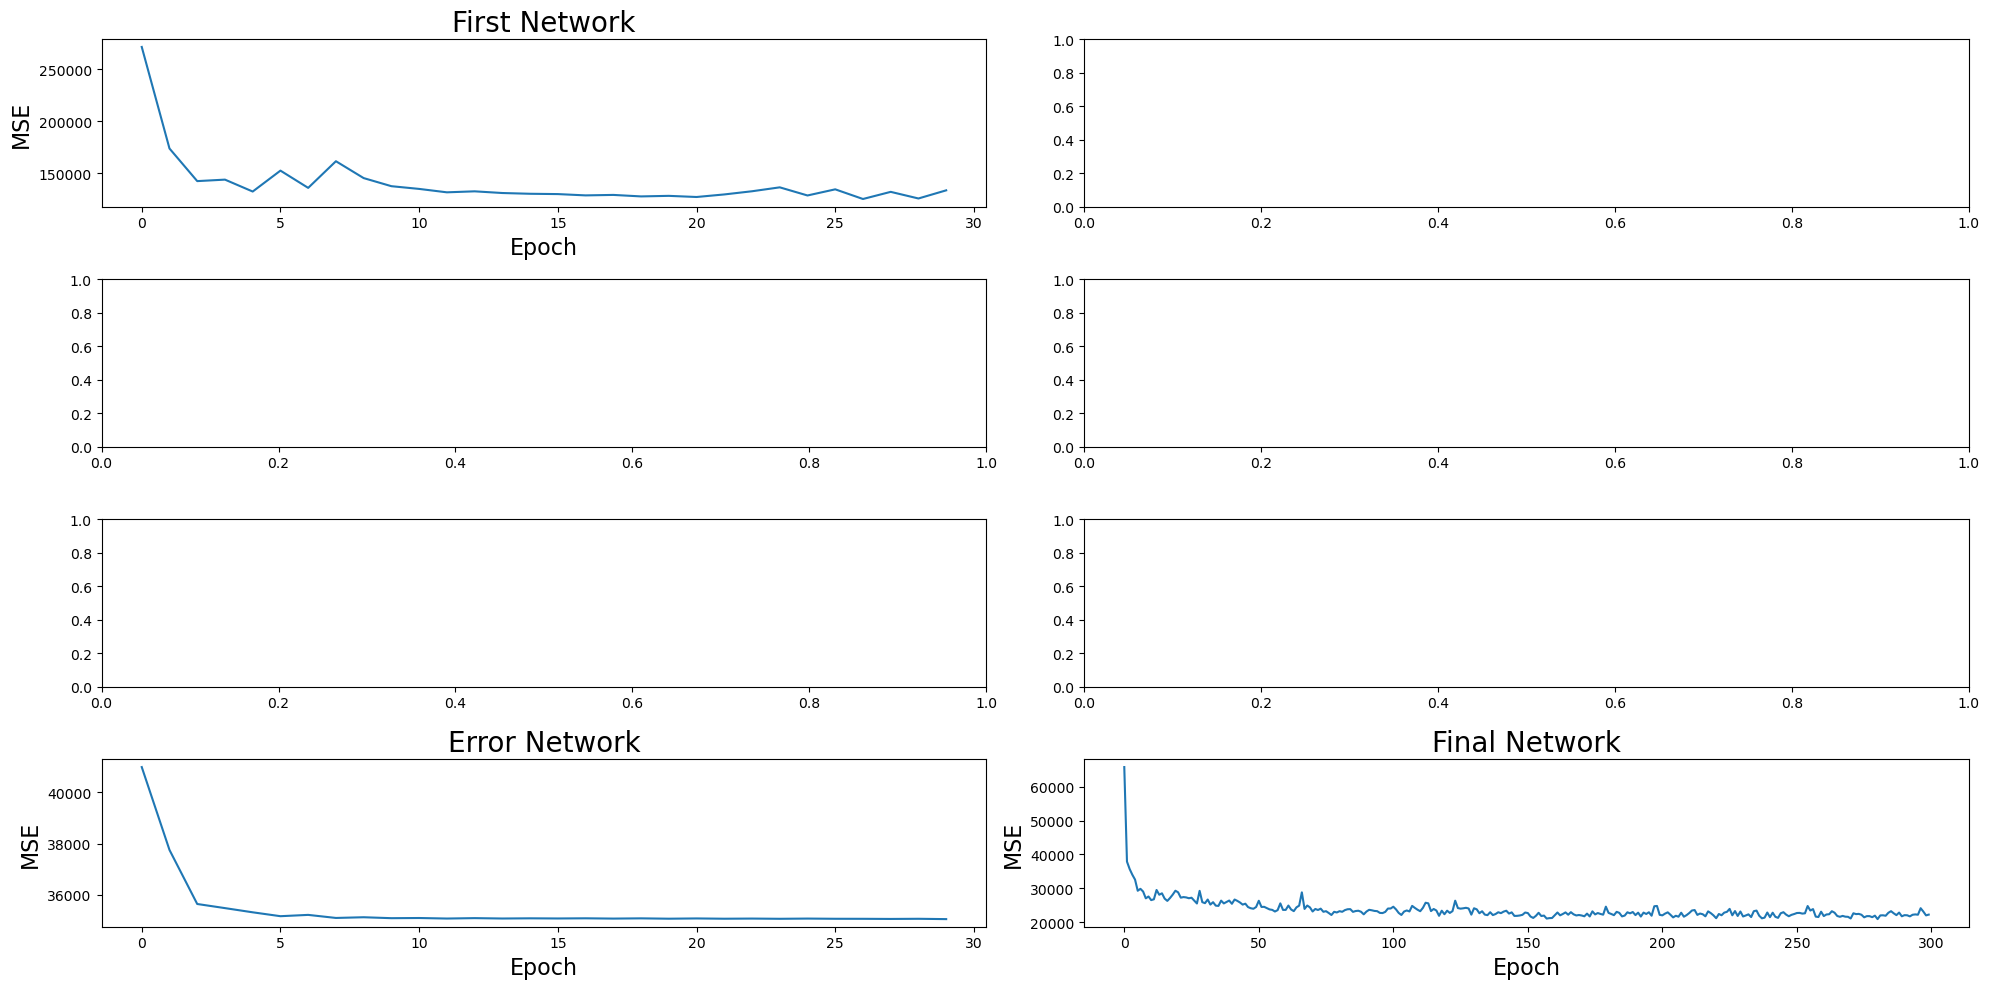

In [82]:
fig, ((ax0,ax1),(ax2,ax3), (ax4,ax5), (ax6,ax7)) = plt.subplots(4,2, figsize=(20,10))

metric = "loss"
x_title = "MSE"
ax0.plot(hist.history[metric])
ax0.set_title("First Network", fontsize=20)
ax0.set_xlabel("Epoch", fontsize=16)
ax0.set_ylabel(x_title, fontsize=16)

ax6.plot(hist_error.history[metric])
ax6.set_title("Error Network", fontsize=20)
ax6.set_xlabel("Epoch", fontsize=16)
ax6.set_ylabel(x_title, fontsize=16)

ax7.plot(hist_final.history[metric])
ax7.set_title("Final Network", fontsize=20)
ax7.set_xlabel("Epoch", fontsize=16)
ax7.set_ylabel(x_title, fontsize=16)


plt.tight_layout()
plt.show()

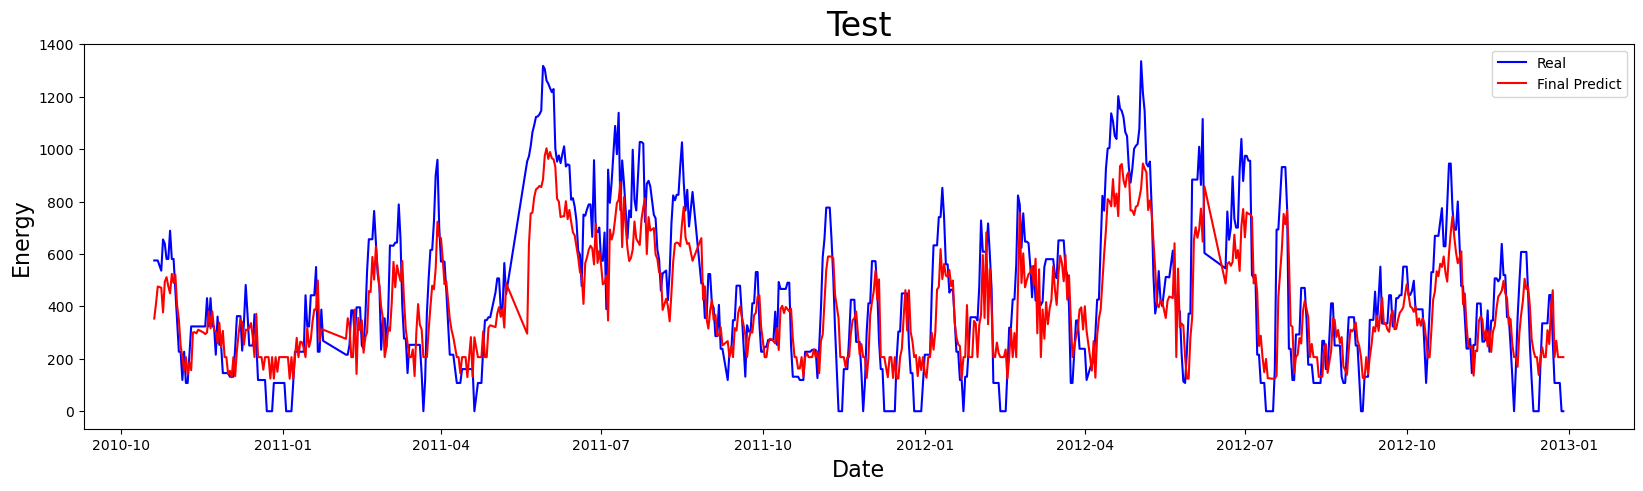

In [83]:
plt.figure(figsize=(20,5), dpi=100)
plt.title("Test", fontsize=24)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Energy", fontsize=16)
plt.plot(energy["date"][ENERGY_SPLIT_INDEX:][~nan_mask_test_join].to_numpy(), y_test_plot, c='b', label="Real")
plt.plot(energy["date"][ENERGY_SPLIT_INDEX:][~nan_mask_test_join].to_numpy(), predict_test_final, c='r', label="Final Predict")
plt.legend()
plt.show()

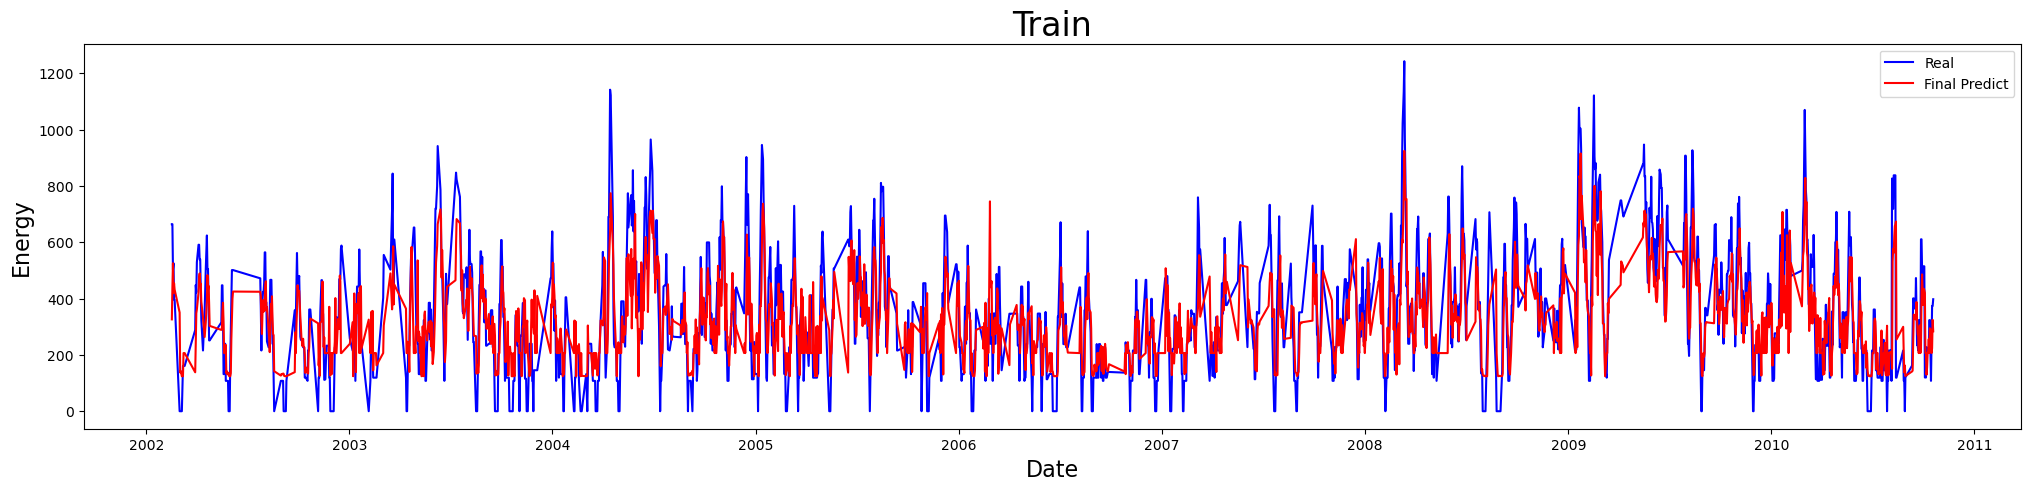

In [84]:
plt.figure(figsize=(25,5), dpi=100)
plt.title("Train", fontsize=24)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Energy", fontsize=16)
plt.plot(energy["date"][:ENERGY_SPLIT_INDEX][~nan_mask_train_join].to_numpy(), y_train_plot, c='b', label="Real")
plt.plot(energy["date"][:ENERGY_SPLIT_INDEX][~nan_mask_train_join].to_numpy(), predict_train_final, c='r', label="Final Predict")
plt.legend()
plt.show()

In [85]:
print("R2\t", "Train: ", r2_score(y_train_plot[1:], y_train_plot[:-1]), "\tTest: ", r2_score(y_test_plot[1:], y_test_plot[:-1]))

R2	 Train:  0.7378441084637891 	Test:  0.8521403113358114


In [86]:
#shifting
for i in range(1,10):
    print("R2", "i=", i, "\t", "Train: ", r2_score(y_train_plot[:-i], predict_train_final[i:]), "\tTest: ", r2_score(y_test_plot[:-i], predict_test_final[i:]))

R2 i= 1 	 Train:  0.7360859076341313 	Test:  0.8140440714358826
R2 i= 2 	 Train:  0.6421653331127195 	Test:  0.7563931642654088
R2 i= 3 	 Train:  0.5019383626712168 	Test:  0.6945702665927438
R2 i= 4 	 Train:  0.3258242855082737 	Test:  0.5843967433124249
R2 i= 5 	 Train:  0.1488192649320359 	Test:  0.4693756329178538
R2 i= 6 	 Train:  -0.01401720910848514 	Test:  0.3538582526810422
R2 i= 7 	 Train:  -0.14358893552605378 	Test:  0.24145407637843286
R2 i= 8 	 Train:  -0.24005922681322223 	Test:  0.12889099238753765
R2 i= 9 	 Train:  -0.2680440879609949 	Test:  0.09139776943709854


In [87]:
print("R2\t", "Train: ", r2_score(y_train_plot, predict_train_final), "\tTest: ", r2_score(y_test_plot[:-1], predict_test_final[:-1]))
print("RMSE\t", "Train: ", mean_squared_error(y_train_plot, predict_train_final, squared=False), "\tTest: ", mean_squared_error(y_test_plot[:-1], predict_test_final[:-1],  squared=False))
print("MAPE\t", "Train: ", mean_absolute_percentage_error(y_train_plot, predict_train_final), "\tTest: ", mean_absolute_percentage_error(y_test_plot[:-1], predict_test_final[:-1]))

R2	 Train:  0.5856783732204627 	Test:  0.711591568232654
RMSE	 Train:  136.5603955032049 	Test:  160.01553878488943
MAPE	 Train:  5.069757970061406e+16 	Test:  5.097662273014971e+16


In [88]:
pd.DataFrame

pandas.core.frame.DataFrame